In [2]:
import torch
import sys
import pyro

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

import numpy as np

from pooledQTL import deconvolve, beta_model, gaussian_model, io_utils, asb_data

from importlib import reload

from pathlib import Path

fdr_threshold = 0.05
device = "cuda:0" if torch.cuda.is_available() else "cpu"
use_structured_guide = True # performs much better

results_dir = Path("/gpfs/commons/home/daknowles/pooledRBPs/results/HNRNPK")

/gpfs/commons/home/daknowles/.conda/envs/asb/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 Load input RNA allelic counts. We should know have good depth for both biological replicates. 

In [98]:
basedir = "/gpfs/commons/home/mschertzer/asb_model/220708_all_ipsc_ip/allelic/"
input_files = [ basedir + "input-rep1_allelic.out", # this is bio rep 1 (two sequencing runs combined)
               basedir + "input-rep2_allelic.out"]

IP_files = [ basedir + "hnrnpk-rep1_allelic.out", 
            basedir + "hnrnpk-rep2_allelic.out" ]

input_counts = [ pd.read_csv(f, sep = "\t", usecols = range(8), index_col = False) for f in input_files ]
input_counts[0].head()

,contig,position,variantID,refAllele,altAllele,refCount,altCount,totalCount
0,chr1,16071,rs541172944,G,A,26,0,26
1,chr1,16141,rs529651976,C,T,52,2,54
2,chr1,16280,.,T,C,29,0,29
3,chr1,128747,rs565117739,A,C,10,1,11
4,chr1,137978,rs529853750,G,A,520,1,521


There is some weirdness where one rsID maps to two positions. deconvolve.merge will just filter these out. 

Observed genotype data (after running StrandScript)

In [11]:
geno = io_utils.loadGenotypes('/gpfs/commons/home/phalmos/genotypes/CIRMlines_flipped.vcf', 
                     maxlines = None, 
                     posterior = False).rename(columns = {"SNP" : "variantID"})
geno.head()

,position,contig,variantID,refAllele,altAllele,CW30274-1-1194512543_CW30274-1-1194512543,CW30454-1-1194512472_CW30454-1-1194512472,CW30421-1-1194512512_CW30421-1-1194512512,CW70372-1-1194512488_CW70372-1-1194512488,CW40201-1-1194512480_CW40201-1-1194512480,CW30525-1-1194512464_CW30525-1-1194512464,CW30190-1-1194512504_CW30190-1-1194512504,CW30108-1-1194512496_CW30108-1-1194512496,CW30154-1-1194512551_CW30154-1-1194512551,CW70179-1-1194512535_CW70179-1-1194512535,CW70142-1-1194512527_CW70142-1-1194512527
rs3131972,752721,chr1,rs3131972,G,A,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5
rs11240777,798959,chr1,rs11240777,G,A,0.0,1.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.5
rs4970383,838555,chr1,rs4970383,N,.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rs4475691,846808,chr1,rs4475691,C,T,0.5,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.5,0.5,1.0
rs13302982,861808,chr1,rs13302982,G,A,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0


# Deconvolution

sum(w)=1.001391 ideally would be 1


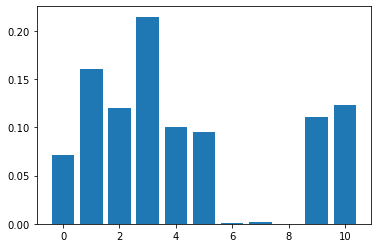

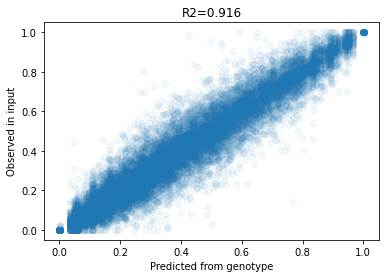

sum(w)=0.998289 ideally would be 1


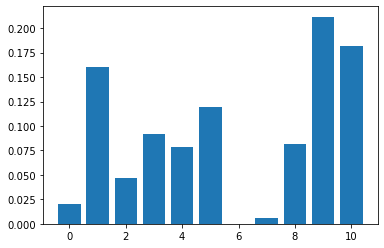

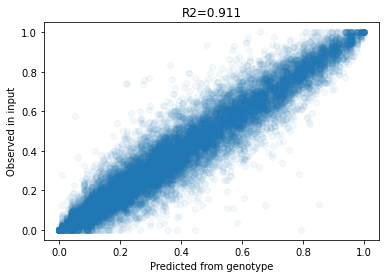

In [12]:
w = [ deconvolve.deconvolve(geno, inp) for inp in input_counts ]

In [13]:
props = pd.DataFrame(w).transpose()
props.columns = ["rep1","rep2"]
props["line"] = geno.columns[5:16]
props.iloc[:,[2,0,1]].to_csv(results_dir / "deconv.tsv", index = False, sep = "\t")

props

,rep1,rep2,line
0,0.071627,0.019891,CW30274-1-1194512543_CW30274-1-1194512543
1,0.160709,0.159960,CW30454-1-1194512472_CW30454-1-1194512472
2,0.120467,0.047090,CW30421-1-1194512512_CW30421-1-1194512512
3,0.214985,0.092138,CW70372-1-1194512488_CW70372-1-1194512488
4,0.100975,0.078045,CW40201-1-1194512480_CW40201-1-1194512480
5,0.094822,0.119431,CW30525-1-1194512464_CW30525-1-1194512464
6,0.001167,0.000000,CW30190-1-1194512504_CW30190-1-1194512504
7,0.002068,0.006409,CW30108-1-1194512496_CW30108-1-1194512496
8,0.000000,0.082046,CW30154-1-1194512551_CW30154-1-1194512551
9,0.110731,0.211748,CW70179-1-1194512535_CW70179-1-1194512535


# Load and check imputed genotypes

In [14]:
sanger_feather = Path("/gpfs/commons/home/daknowles/pooledRBPs/genotypes/sanger.feather")
sanger = pd.read_feather(sanger_feather)
del sanger["index"]

In [15]:
sanger = sanger[sanger.SNP != "."]
sanger = sanger[~sanger.SNP.duplicated()] # this removes triallelic SNPs, which I don't think we know how to handle anyway

cols = list(sanger.columns)
cols[0], cols[1] = cols[1], cols[0]
sanger = sanger.loc[:,cols]

# Load IP count data and join with input and genotype

In [16]:
IP_counts = [ pd.read_csv(f, sep = "\t", usecols = range(8), index_col = False) for f in IP_files ]

With the new data the counts are similiar for both bio replicates:

In [9]:
[ g.totalCount.sum()/1e6 for g in IP_counts ]

[551.655497, 342.291892]

In [10]:
[ g.totalCount.sum()/1e6 for g in input_counts ]

[453.871685, 439.627239]

Joining genotype and input allelic counts


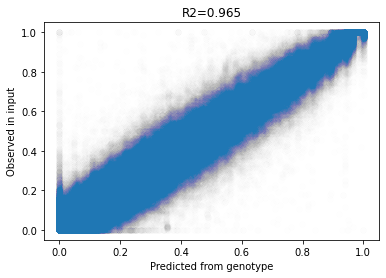

Joining genotype+input with IP allelic counts
Joining genotype and input allelic counts


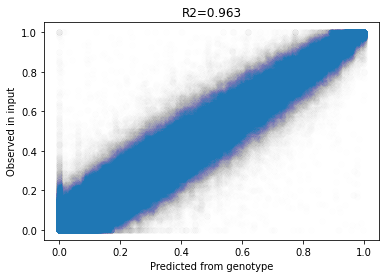

Joining genotype+input with IP allelic counts


In [17]:
merged = {} 
dat_sub = {}
for rep_index in range(2):
    merged[rep_index],dat_sub[rep_index] = deconvolve.merge_geno_and_counts(sanger, 
                                                                            input_counts[rep_index], 
                                                                            IP_counts[rep_index], 
                                                                            w[rep_index], 
                                                                            plot = True)

# Run beta models

This can't handle replicates. 

In [2]:
reload(beta_model)
for count_conc in [50., 100., 200., 300., 500., 1000.]:
    for rep_index in range(len(merged)):

        results = beta_model.fit_and_save(dat_sub[rep_index], 
                                          input_count_conc = count_conc, 
                                          IP_count_conc = count_conc, 
                                                results_file =  results_dir / ("beta" 
                                                                + ("%.1f" % count_conc)
                                                                + ("_rep%i.tsv.gz" % rep_index)),
                                                 use_structured_guide = use_structured_guide,
                                                 iterations = 1000,
                                                 device = device)


1

In [3]:
reload(beta_model)

count_conc = 250. 
for conc in [1., 2., 3., 5., .10, 20., 30., 50., 100.]:
    print(conc)
    for rep_index in range(len(merged)):

        results = beta_model.fit_and_save(dat_sub[rep_index], 
                                          input_conc = conc, 
                                          IP_conc = conc, 
                                          input_count_conc = count_conc, 
                                          IP_count_conc = count_conc, 
                                                results_file =  results_dir / ("beta_conc" 
                                                                + ("%.1f" % conc)
                                                                + ("_rep%i.tsv.gz" % rep_index)),
                                                 use_structured_guide = use_structured_guide,
                                                 iterations = 1000,
                                                 device = device)


1

In [20]:
1

1

In [13]:
import torch
import sys
import pyro

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

import numpy as np

import scipy.stats
import statsmodels.stats.multitest
from scipy.special import logit


from importlib import reload

from pathlib import Path
results_dir = Path("/gpfs/commons/home/daknowles/pooledRBPs/results/HNRNPK")

fdr_threshold = 0.05
correlations = {} 
cols_to_keep = ["variantID", "refAllele", "altAllele", "ase_q", "ase_loc", "ase_sd", "asb_q", "asb_loc", "asb_sd"]


def comparer(
    dat, 
    which = [("ase", "beta"),("asb","beta")], 
    threshold = 0.05,
    plot = True
):
    
    is_sig = [ (dat[ "%s_q%s" % g ] < threshold) for g in which ]    
    for j,k in ((0,1),(1,0)):
        subset_sig = is_sig[j][ is_sig[k] ].mean()
        backg_sig = is_sig[j].mean()
        if plot: print("Prop significant for %s (%s)" % which[j], 
              "out of %s (%s) hits:" % which[k], 
              "%.3f" % subset_sig, 
             "(%.3f background rate, x%.2f enrichment)" % (backg_sig, subset_sig/backg_sig))
    effs = [ dat[ "%s_loc%s" % g] for g in which ]
    x_col,y_col = [ "%s_loc%s" % g for g in which ]
    
    raw_correlation = scipy.stats.pearsonr(dat[x_col],dat[y_col])
    sig_in_either = dat[is_sig[0] | is_sig[1]]
    
    if plot: 
        print("Correlation of effect sizes %.3f (p=%.3g)" 
              % raw_correlation) 
        print("Correlation of sig effect sizes %.3f (p=%.3g)" 
              % scipy.stats.pearsonr(sig_in_either[x_col],sig_in_either[y_col])) 
        print("Prop sig effect sizes with matching sign %.3f" 
              % ((sig_in_either[x_col]>0)==(sig_in_either[y_col]>0)).mean())

        plt.figure(figsize=(5,4))
        # sns.scatterplot(data = dat, x="%s_loc%s" % which[0], y="%s_loc%s" % which[1], hue = "hue", alpha = 0.1, linewidth=0)
        sns.scatterplot(data = dat[~is_sig[0] & ~is_sig[1]], 
                        x=x_col, 
                        y=y_col, 
                        label = "insig",
                        color="gray", alpha = 1, linewidth=0)
        sns.scatterplot(data = dat[is_sig[0] & ~is_sig[1]], 
                        x=x_col, 
                        y=y_col, 
                        label = "sig for %s%s only" % which[0], 
                        color="red", alpha = 0.2, linewidth=0)
        sns.scatterplot(data = dat[~is_sig[0] & is_sig[1]], 
                        x=x_col, 
                        y=y_col, 
                        label = "sig for %s%s only" % which[1], 
                        color="green", alpha = 0.2, linewidth=0)
        sns.scatterplot(data = dat[is_sig[0] & is_sig[1]], 
                        x=x_col, 
                        y=y_col, 
                        label = "sig in both",
                        color="blue", alpha = 0.3, linewidth=0)
        #sns.kdeplot(dat.loc[:,x_col], dat.loc[:,y_col], bw_method = 0.1, levels = 4)
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        plt.show()
    
    return raw_correlation[0]


Fixed likelihood conc (250), but varying (and the same) concentration DNA->RNA, and RNA->RBP. 

In [8]:
correlations = {}

count_conc = 250. 
for conc in [1., 2., 3., 5., .10, 20., 30., 50., 100.]:
    print(conc)
    correlations[conc] = {}
    res_beta = [ pd.read_csv(results_dir / ("beta_conc" + ("%.1f" % conc) + ("_rep%i.tsv.gz" % i)), sep = "\t", index_col = False) for i in range(2) ]
    res_sub_beta = [ g.loc[:,cols_to_keep] for g in res_beta ]
    merged_beta = res_sub_beta[0].merge(res_sub_beta[1], on = ["variantID", "refAllele", "altAllele"], suffixes=["_1","_2"])
    correlations[conc]["ase_reps"] = comparer(
        merged_beta, 
        [("ase","_1"),("ase","_2")], 
        plot = False )
    correlations[conc]["asb_reps"] = comparer(
        merged_beta, 
        [("asb","_1"),("asb","_2")], 
        plot = False) 
    for i in range(2):
        #print("Replicate %i -----------" % (i+1))
        correlations[conc]["ase_v_asb_%i" % (i+1)] = comparer(
            res_sub_beta[i], 
            [("ase",""),("asb","")], 
            plot = False
        )          

1.0
2.0
3.0
5.0
0.1
20.0
30.0
50.0
100.0


A lot more come out as significant using the beta model

In [9]:
correlations

{1.0: {'ase_reps': 0.4041554395092785,
  'asb_reps': 0.14441408257681118,
  'ase_v_asb_1': -0.54713475499587,
  'ase_v_asb_2': -0.4866808634655492},
 2.0: {'ase_reps': 0.4068610564806556,
  'asb_reps': 0.13691191895583948,
  'ase_v_asb_1': -0.5267692713004939,
  'ase_v_asb_2': -0.4659754309822477},
 3.0: {'ase_reps': 0.41081396571412354,
  'asb_reps': 0.12957319983814547,
  'ase_v_asb_1': -0.5091891221287758,
  'ase_v_asb_2': -0.4477304803171962},
 5.0: {'ase_reps': 0.4215186544350776,
  'asb_reps': 0.12113190057042947,
  'ase_v_asb_1': -0.47747213746255746,
  'ase_v_asb_2': -0.4154050823994106},
 0.1: {'ase_reps': 0.4063259393029341,
  'asb_reps': 0.1580769773189232,
  'ase_v_asb_1': -0.5680086764928094,
  'ase_v_asb_2': -0.5087939879642802},
 20.0: {'ase_reps': 0.47375655541422923,
  'asb_reps': 0.0963170497829981,
  'ase_v_asb_1': -0.32906632216499454,
  'ase_v_asb_2': -0.26943488526780557},
 30.0: {'ase_reps': 0.49147045431801434,
  'asb_reps': 0.08882922978041027,
  'ase_v_asb_1':

Text(0, 0.5, 'Correlation between replicates for ASE')

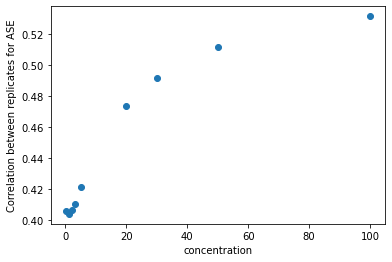

In [16]:
plt.scatter(*zip(*[ (k , v["ase_reps"]) for k,v in correlations.items() ]))
plt.xlabel("concentration")
plt.ylabel("Correlation between replicates for ASE")

Text(0, 0.5, 'Correlation between replicates for ASB')

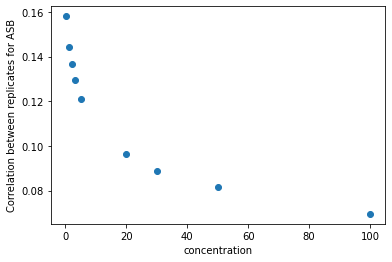

In [18]:
plt.scatter(*zip(*[ (k , v["asb_reps"]) for k,v in correlations.items() ]))
plt.xlabel("concentration")
plt.ylabel("Correlation between replicates for ASB")

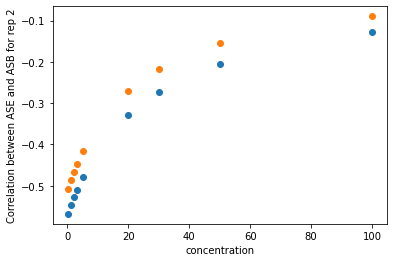

In [23]:
for i in [1,2]: 
    plt.scatter(*zip(*[ (k , v["ase_v_asb_%i" % i]) for k,v in correlations.items() ]))
    plt.xlabel("concentration")
    plt.ylabel("Correlation between ASE and ASB for rep %i" % i)


In [ ]:
Vary likelihood conc, but learn prior concs. 

In [26]:
correlations = {}

for count_conc in [50., 100., 200., 300., 500., 1000.]:
    correlations[count_conc] = {}

    res_beta = [ pd.read_csv(
        results_dir / ("beta" 
        + ("%.1f" % count_conc)
        + ("_rep%i.tsv.gz" % i)) , sep = "\t", index_col = False) for i in range(2) ]
    res_sub_beta = [ g.loc[:,cols_to_keep] for g in res_beta ]
    merged_beta = res_sub_beta[0].merge(res_sub_beta[1], on = ["variantID", "refAllele", "altAllele"], suffixes=["_1","_2"])
    correlations[count_conc]["ase_reps"] = comparer(
        merged_beta, 
        [("ase","_1"),("ase","_2")], 
        plot = False )
    correlations[count_conc]["asb_reps"] = comparer(
        merged_beta, 
        [("asb","_1"),("asb","_2")], 
        plot = False) 
    for i in range(2):
        #print("Replicate %i -----------" % (i+1))
        correlations[count_conc]["ase_v_asb_%i" % (i+1)] = comparer(
            res_sub_beta[i], 
            [("ase",""),("asb","")], 
            plot = False
        )         

Text(0, 0.5, 'Correlation between replicates for ASE')

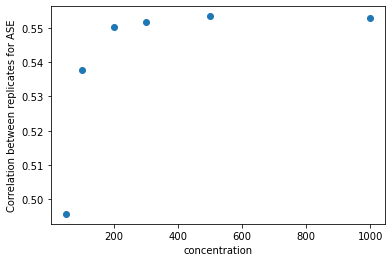

In [27]:
plt.scatter(*zip(*[ (k , v["ase_reps"]) for k,v in correlations.items() ]))
plt.xlabel("concentration")
plt.ylabel("Correlation between replicates for ASE")

Text(0, 0.5, 'Correlation between replicates for ASB')

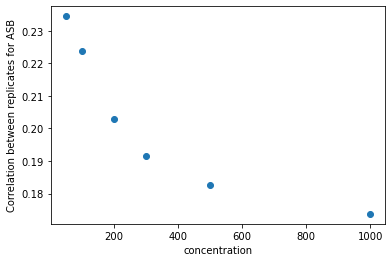

In [28]:
plt.scatter(*zip(*[ (k , v["asb_reps"]) for k,v in correlations.items() ]))
plt.xlabel("concentration")
plt.ylabel("Correlation between replicates for ASB")

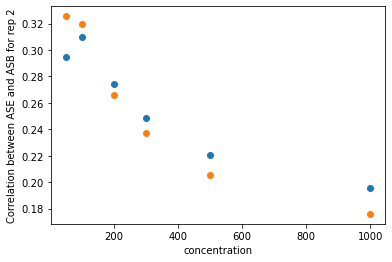

In [29]:
for i in [1,2]: 
    plt.scatter(*zip(*[ (k , v["ase_v_asb_%i" % i]) for k,v in correlations.items() ]))
    plt.xlabel("concentration")
    plt.ylabel("Correlation between ASE and ASB for rep %i" % i)


## Random search

Could try this with the replicates model? Given the concern raised at CSHL about the identifiability of the ASB effect (what is noise vs ASB). 

In [3]:
reload(beta_model)
reload(gaussian_model)
all_res = []
for rand_ind in range(1000):
    print(rand_ind, end="\r")
    res = {}
    res["input_conc"] = float(np.random.choice([1., 2., 3., 5., 10., 20., 30., 50., 100., 200., 300.]) )
    res["IP_conc"] = float(np.random.choice([1., 2., 3., 5., 10., 20., 30., 50., 100., 200., 300.]) )
    res["input_count_conc"] = float(np.random.choice([50., 100., 200., 300., 500., 1000., 2000.]))
    res["IP_count_conc"] = float(np.random.choice([50., 100., 200., 300., 500., 1000., 2000.]))
    
    res_beta = [ beta_model.fit_and_save(dat_sub[rep_index], 
                                          input_conc = res["input_conc"], 
                                          IP_conc = res["IP_conc"], 
                                          input_count_conc = res["input_count_conc"], 
                                          IP_count_conc = res["IP_count_conc"], 
                                         results_file = "temp",
                                                 use_structured_guide = use_structured_guide,
                                                 iterations = 1000,
                                                 device = device) for rep_index in range(len(merged)) ]
        
    res_sub_beta = [ g.loc[:,cols_to_keep] for g in res_beta ]
    merged_beta = res_sub_beta[0].merge(res_sub_beta[1], on = ["variantID", "refAllele", "altAllele"], suffixes=["_1","_2"])
    res["ase_reps"] = comparer(
        merged_beta, 
        [("ase","_1"),("ase","_2")], 
        plot = False )
    res["asb_reps"] = comparer(
        merged_beta, 
        [("asb","_1"),("asb","_2")], 
        plot = False) 
    for i in range(2) : 
        res["ase_v_asb_%i" % i] = comparer(
            res_sub_beta[i], 
            [("ase",""),("asb","")], 
            plot = False
        )  
    all_res.append(res)
    pd.DataFrame(all_res).to_csv("random_hyper_search.tsv", index = False, sep = "\t")
    
          


1

In [3]:
df = pd.read_csv("random_hyper_search.tsv", sep = "\t")
df["mean_ase_vs_asb"] = 0.5 * (df.ase_v_asb_0 +  df.ase_v_asb_1)
df["mean_ase_vs_asb_abs"] = df.mean_ase_vs_asb.abs()

Text(0, 0.5, 'ASB replicate corr (high good)')

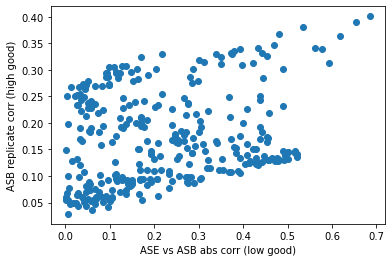

In [7]:
plt.scatter(df.mean_ase_vs_asb_abs, df.asb_reps)
plt.xlabel("ASE vs ASB abs corr (low good)")
plt.ylabel("ASB replicate corr (high good)")

So we want things in the top left of the above plot, and the top of the following table. Should also try the second row. 

In [9]:
df[df.mean_ase_vs_asb_abs < 0.02].sort_values("asb_reps", ascending = False)

,input_conc,IP_conc,input_count_conc,IP_count_conc,ase_reps,asb_reps,ase_v_asb_0,ase_v_asb_1,mean_ase_vs_asb,mean_ase_vs_asb_abs
105,100.0,2.0,100.0,300.0,0.468133,0.267722,0.008603,0.017883,0.013243,0.013243
190,100.0,3.0,200.0,200.0,0.481546,0.249848,-0.002280,0.008306,0.003013,0.003013
63,50.0,10.0,200.0,2000.0,0.489284,0.198829,-0.018436,0.005506,-0.006465,0.006465
174,20.0,20.0,100.0,2000.0,0.508914,0.149606,-0.022618,0.018075,-0.002271,0.002271
264,20.0,30.0,200.0,2000.0,0.514887,0.129161,-0.034153,0.002424,-0.015864,0.015864
228,30.0,100.0,2000.0,100.0,0.532047,0.100645,-0.015654,0.002165,-0.006745,0.006745
148,30.0,200.0,2000.0,100.0,0.544407,0.076479,0.002526,0.013778,0.008152,0.008152
28,3.0,100.0,100.0,300.0,0.540030,0.068694,-0.019322,0.025178,0.002928,0.002928
244,5.0,200.0,300.0,1000.0,0.549646,0.060446,-0.008852,0.012749,0.001948,0.001948
93,50.0,300.0,2000.0,50.0,0.543665,0.057562,-0.001035,0.005736,0.002350,0.002350


In [18]:
res = {}

res_beta = [ beta_model.fit_and_save(
    dat_sub[rep_index], 
    input_conc = 100., # aggressive regularization on ASE
    IP_conc = 2.,  # very light regularization on ASB
    input_count_conc = 100., # kinda weird not having these be the same? 
    IP_count_conc = 300., 
    results_file = results_dir / (
        "beta_corr_opt" + ("_struct" if use_structured_guide else "") 
        + ("_rep%i.tsv.gz" % rep_index)),
    use_structured_guide = use_structured_guide,
    iterations = 1000,
    device = device) for rep_index in range(len(merged)) ]


Learned hyperparameters: {}946
Learned hyperparameters: {}051


NameError: name 'cols_to_keep' is not defined

Prop significant for ase (_1) out of ase (_2) hits: 0.386 (0.025 background rate, x15.43 enrichment)
Prop significant for ase (_2) out of ase (_1) hits: 0.388 (0.025 background rate, x15.43 enrichment)
Correlation of effect sizes 0.467 (p=0)
Correlation of sig effect sizes 0.777 (p=0)
Prop sig effect sizes with matching sign 0.909


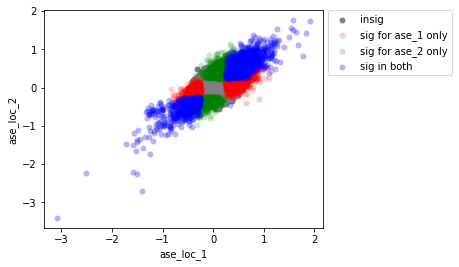

Prop significant for asb (_1) out of asb (_2) hits: 0.205 (0.104 background rate, x1.96 enrichment)
Prop significant for asb (_2) out of asb (_1) hits: 0.238 (0.121 background rate, x1.96 enrichment)
Correlation of effect sizes 0.268 (p=0)
Correlation of sig effect sizes 0.342 (p=0)
Prop sig effect sizes with matching sign 0.697


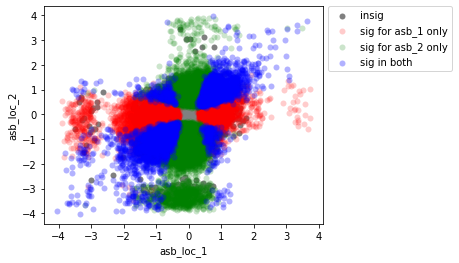

Prop significant for ase () out of asb () hits: 0.071 (0.022 background rate, x3.29 enrichment)
Prop significant for asb () out of ase () hits: 0.362 (0.110 background rate, x3.29 enrichment)
Correlation of effect sizes 0.008 (p=5.64e-07)
Correlation of sig effect sizes 0.146 (p=1.43e-204)
Prop sig effect sizes with matching sign 0.554


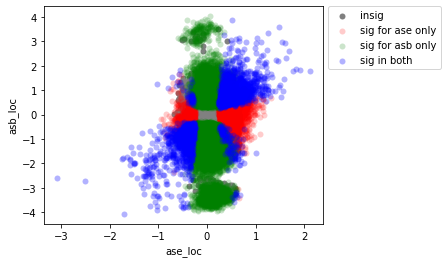

Prop significant for ase () out of asb () hits: 0.074 (0.025 background rate, x2.94 enrichment)
Prop significant for asb () out of ase () hits: 0.366 (0.125 background rate, x2.94 enrichment)
Correlation of effect sizes 0.018 (p=7.8e-19)
Correlation of sig effect sizes 0.137 (p=1.77e-144)
Prop sig effect sizes with matching sign 0.548


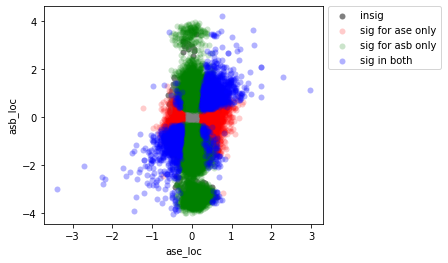

In [15]:
res = {}
res_beta = [ results_dir / ("beta_corr_opt" 
                        + ("_struct" if use_structured_guide else "") 
                        + ("_rep%i.tsv.gz" % rep_index)) for rep_index in range(2) ]
res_beta = [ pd.read_csv(f, sep = "\t") for f in res_beta ]

res_sub_beta = [ g.loc[:,cols_to_keep] for g in res_beta ]
merged_beta = res_sub_beta[0].merge(res_sub_beta[1], on = ["variantID", "refAllele", "altAllele"], suffixes=["_1","_2"])
res["ase_reps"] = comparer(
    merged_beta, 
    [("ase","_1"),("ase","_2")], 
    plot = True )
res["asb_reps"] = comparer(
    merged_beta, 
    [("asb","_1"),("asb","_2")], 
    plot = True) 
for i in range(2) : 
    res["ase_v_asb_%i" % i] = comparer(
        res_sub_beta[i], 
        [("ase",""),("asb","")], 
        plot = True
    )  

In [16]:
res

{'ase_reps': 0.46742297690129153,
 'asb_reps': 0.26770792465577103,
 'ase_v_asb_0': 0.008449263954487524,
 'ase_v_asb_1': 0.017834471386484377}

In [44]:
snp_features

,chr,start,end,variantID,gene_overlap,gene_feature,hk_peak_overlap,rbfox2_peak_overlap,hnrnpa1_peak_overlap
0,chr10,249013,249014,rs1017361,genic,Exon,No,No,No
1,chr10,275014,275015,rs10903832,genic,3UTR,No,No,Yes
2,chr10,279194,279195,rs12357593,genic,Intron,No,No,No
3,chr10,281840,281841,rs7908298,genic,Intron,No,No,No
4,chr10,301812,301813,rs7918643,genic,Intron,Yes,No,No
...,...,...,...,...,...,...,...,...,...
350632,chr9,138109082,138109083,rs9410071,genic,Intron,No,No,No
350633,chr9,138109494,138109495,rs7357733,genic,Intron,No,No,No
350634,chr9,138111320,138111321,rs766373,genic,Intron,No,Yes,No
350635,chr9,138111368,138111369,rs766375,genic,Intron,No,Yes,No


In [26]:
merged_beta["conf_asb"] = (merged_beta["asb_q_1"] < 0.1) & (merged_beta["asb_q_2"] < 0.1) & \
( np.sign(merged_beta["asb_loc_1"]) == np.sign(merged_beta["asb_loc_2"]))

In [69]:
meta_z = merged_beta.asb_loc_1 / merged_beta.asb_sd_1 + merged_beta.asb_loc_2 / merged_beta.asb_sd_2 
meta_z /= np.sqrt(2) # variance=2 because adding 2 independent z-scores (under null)
meta_p = scipy.stats.norm().cdf(-np.abs(meta_z)) 
np.mean(meta_p < 0.01), np.sum(meta_p < 0.01)
merged_beta["meta_asb_q"] = meta_p

In [31]:
snp_features = pd.read_csv(
    "/gpfs/commons/home/mschertzer/asb_model/220708_all_ipsc_ip/221014_snp_gene_features_table.txt",
    sep = "\t"
).rename(columns = {"id" : "variantID"})

In [70]:
merged2 = merged_beta.merge(snp_features, on = "variantID")

In [108]:

def assess_overlap(sig_asb):
    peaks = ["hk_peak_overlap", "rbfox2_peak_overlap", "hnrnpa1_peak_overlap"]

    enrich = {}
    for peak in peaks:
        tab = pd.crosstab(sig_asb, merged2[peak])
        c, p, dof, expected = scipy.stats.chi2_contingency(tab)
        enrich[peak] = {
            "enrichment":tab.iloc[1,1] / expected[1,1], 
            "p":p }

    for gene_feature in ["Exon","Intron","3UTR","none"]:
        tab = pd.crosstab(sig_asb, merged2.gene_feature == gene_feature)
        c, p, dof, expected = scipy.stats.chi2_contingency(tab)
        enrich["Feature:"+gene_feature] = {
            "enrichment":tab.iloc[1,1] / expected[1,1], 
            "p":p }

    tab = pd.crosstab(sig_asb, merged2.gene_overlap == "genic")
    c, p, dof, expected = scipy.stats.chi2_contingency(tab)
    enrich["genic"] = {
            "enrichment":tab.iloc[1,1] / expected[1,1], 
            "p":p }

    return pd.DataFrame(enrich).transpose()
    
assess_overlap(merged2.conf_asb)

,enrichment,p
hk_peak_overlap,1.164195,3.177111e-17
rbfox2_peak_overlap,1.235600,9.654024e-15
hnrnpa1_peak_overlap,1.065172,1.241070e-01
Feature:Exon,0.848551,5.044749e-05
Feature:Intron,0.958372,2.872308e-20
Feature:3UTR,0.856577,6.707219e-06
Feature:none,2.093719,3.383623e-157
genic,0.942959,3.383623e-157


In [109]:
assess_overlap(merged_beta["meta_asb_q"] < 0.01)

,enrichment,p
hk_peak_overlap,1.186433,7.044469e-22
rbfox2_peak_overlap,1.259369,1.209450e-17
hnrnpa1_peak_overlap,1.074578,7.699659e-02
Feature:Exon,0.786842,1.000410e-08
Feature:Intron,0.958776,5.132841e-20
Feature:3UTR,0.815111,5.638763e-09
Feature:none,2.227850,8.903980e-199
genic,0.935964,8.903980e-199


In [110]:
np.mean(merged_beta["meta_asb_q"] < 0.01), np.mean(merged_beta["conf_asb"])

(0.051607724632891074, 0.05131970347986213)

In [237]:
vc = merged2.gene_feature.value_counts()
vc/vc.sum()

Intron    0.811209
3UTR      0.079805
Exon      0.059417
none      0.049568
Name: gene_feature, dtype: float64

In [242]:
peaks = ["hk_peak_overlap", "rbfox2_peak_overlap", "hnrnpa1_peak_overlap"]
{ peak: np.mean(merged2[peak] == "Yes") for peak in peaks }

{'hk_peak_overlap': 0.1878511733320742,
 'rbfox2_peak_overlap': 0.08652438736484254,
 'hnrnpa1_peak_overlap': 0.04767930497190613}

# Want probability(ASB) (and maybe ASE) as a funciton of input and IP total count. 


In [118]:
np.mean(res_beta[0].asb_q < 0.02)

0.04977512356083357

In [119]:
res_beta[0]

,contig,position_hg19,variantID,refAllele,altAllele,position,refCount_input,altCount_input,totalCount_input,pred_ratio,...,altCount_IP,totalCount_IP,shrunk_input_logratio,ase_loc,ase_sd,ase_q,shrunk_IP_logratio,asb_loc,asb_sd,asb_q
0,chr10,294953,rs1017361,A,G,249013,18,109,127,0.925054,...,34,36,2.194653,-0.318434,0.271874,0.120748,2.857364,0.662711,0.875803,0.224618
1,chr10,320954,rs10903832,A,G,275014,98,24,122,0.191076,...,6,36,-1.402501,0.040533,0.202135,0.420535,-1.722425,-0.319924,0.518257,0.268516
2,chr10,325134,rs12357593,C,T,279194,10,4,14,0.214894,...,5,38,-1.260478,0.035195,0.219364,0.436267,-1.875011,-0.614533,0.599997,0.152864
3,chr10,327780,rs7908298,C,T,281840,11,7,18,0.410334,...,14,34,-0.409376,-0.046791,0.192424,0.403939,-0.336099,0.073277,0.400054,0.427334
4,chr10,347752,rs7918643,C,T,301812,12,9,21,0.302841,...,10,52,-0.670052,0.163753,0.174809,0.174443,-1.484077,-0.814025,0.300063,0.003335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350632,chr9,141003534,rs9410071,G,A,138109082,17,15,32,0.613606,...,35,61,0.294452,-0.168042,0.163440,0.151938,0.338210,0.043758,0.252937,0.431327
350633,chr9,141003946,rs7357733,G,T,138109494,10,23,33,0.595935,...,26,51,0.409319,0.020763,0.167224,0.450593,0.097923,-0.311396,0.342537,0.181652
350634,chr9,141005772,rs766373,A,G,138111320,16,27,43,0.647088,...,31,51,0.649175,0.042912,0.171681,0.401312,0.389101,-0.260074,0.406316,0.261061
350635,chr9,141005820,rs766375,C,T,138111368,28,11,39,0.254254,...,17,54,-1.095572,-0.019520,0.214336,0.463717,-0.879872,0.215701,0.334102,0.259265


(array([32.,  2.,  2.,  1.,  2.,  9.,  8.,  9.,  5., 11.]),
 array([-1.        , -0.44018872,  0.11962257,  0.67943385,  1.23924513,
         1.79905641,  2.3588677 ,  2.91867898,  3.47849026,  4.03830155,
         4.59811283]),
 <BarContainer object of 10 artists>)

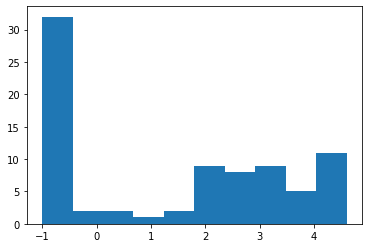

In [244]:
bins = [0,10,20,30,50,100,500,1000,2000,5000]
res_beta[0]["totalCount_input_cut"] = pd.cut(res_beta[0].totalCount_input, bins = bins)
res_beta[0]["totalCount_IP_cut"] = pd.cut(res_beta[0].totalCount_IP, bins = bins)
res_beta[0]["asb_sig"] = res_beta[0].asb_q < 0.01
res_beta[0]["ase_sig"] = res_beta[0].ase_q < 0.01
tab = res_beta[0].groupby(["totalCount_IP_cut", "totalCount_input_cut"]).agg(
    prop_asb_sig = pd.NamedAgg("asb_sig","mean"),
    prop_ase_sig = pd.NamedAgg("ase_sig","mean"),
    num_snps = pd.NamedAgg("asb_sig","size"),
).reset_index()
plt.hist(np.log10(tab.num_snps + 0.1))

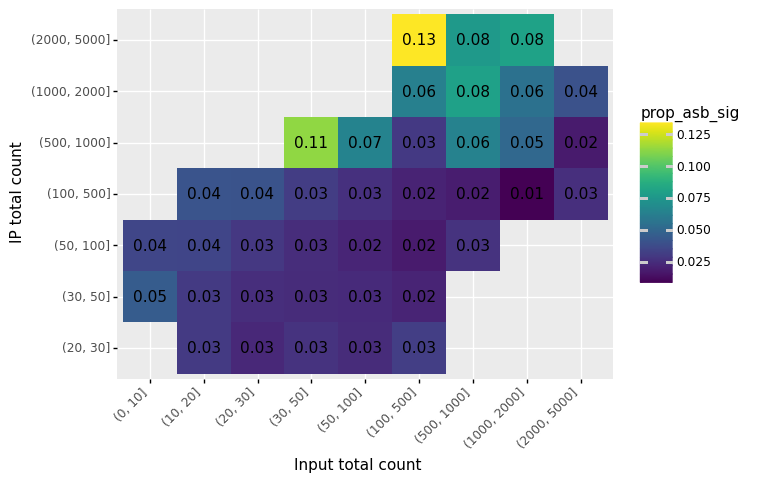

<ggplot: (8748789292421)>

In [247]:
import plotnine as p9
tab_filt = tab[tab.num_snps >= 100].copy()
( p9.ggplot(tab_filt) + 
 p9.aes(x = "totalCount_input_cut", y = "totalCount_IP_cut", fill = "prop_asb_sig", label = "prop_asb_sig") + 
 p9.geom_tile() + 
 p9.geom_text(format_string = "{:.2f}") + 
 p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1)) + 
 p9.xlab("Input total count") + 
 p9.ylab("IP total count")
)

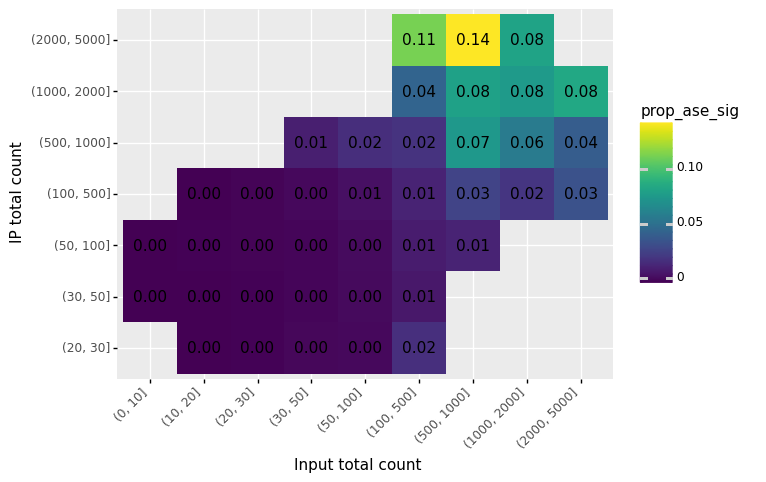

<ggplot: (8748788972864)>

In [248]:
tab_filt = tab[tab.num_snps >= 100].copy()
( p9.ggplot(tab_filt) + 
 p9.aes(x = "totalCount_input_cut", y = "totalCount_IP_cut", fill = "prop_ase_sig", label = "prop_ase_sig") + 
 p9.geom_tile() + 
 p9.geom_text(format_string = "{:.2f}") + 
 p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1)) + 
 p9.xlab("Input total count") + 
 p9.ylab("IP total count")
)

In [ ]:
res_beta[0]
res_beta[0].groupby("totalCount_input_cut").agg({"asb_sig":"mean"})

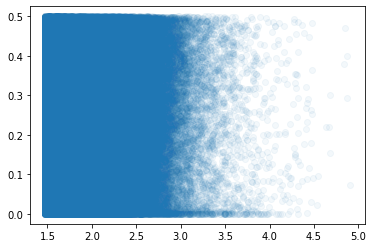

In [123]:
plt.scatter(np.log10(res_beta[0].totalCount_IP), res_beta[0].asb_q, alpha=0.05)